In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
path = 'ebw_data.csv'
data = pd.read_csv(path)

data.info()
# все признаки числовые

data.isna().sum()
# пропусков нет


data.shape
# но данных очень мало, всего 72 замера, нет практического смысла использовать нейросеть

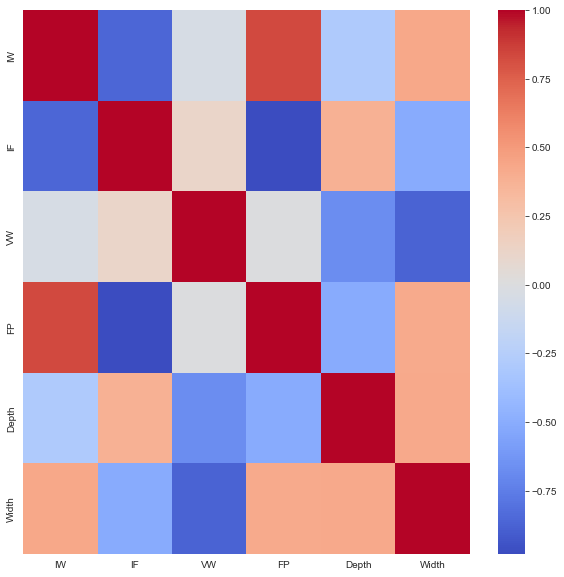

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.861073,-0.043430,0.835530,-0.289568,0.434869
IF,-0.861073,1.000000,0.115093,-0.980562,0.376084,-0.510167
VW,-0.043430,0.115093,1.000000,-0.001060,-0.671437,-0.874257
FP,0.835530,-0.980562,-0.001060,1.000000,-0.510748,0.412962
Depth,-0.289568,0.376084,-0.671437,-0.510748,1.000000,0.425391
Width,0.434869,-0.510167,-0.874257,0.412962,0.425391,1.000000


In [34]:
# Это однозначно задача регрессии, так что попробуем понять какие данные коррелируют с целевыми больше всего
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), cmap='coolwarm')
plt.show()

# Диаграмма не лучшим образом это отражает, визуально проще судить по матрице
data.corr()
# IW - величина сварочного тока 
# IF - ток фокусировки электронного пучка
# VW - скорость сварки
# FP - расстояние от поверхности образцов 

# Width наиболее сильная отрицательная корреляция с VW: -0.874
# Depth тоже наиболее сильная отрицательная корреляция с VW: -0.671

# есть очень сильная отрицательная корреляция между FP и IF
# возможно с увеличением расстояния необходимо уменьшать ток фокусировки

# есть сильная положительная корреляция между IW и FP
# возможно ток необходимо увеличивать прямо пропорционально расстоянию
# так что может иметь смысл выбросить из расчётов один из параметров для избежания негатвного влияния мультиколлинеарности

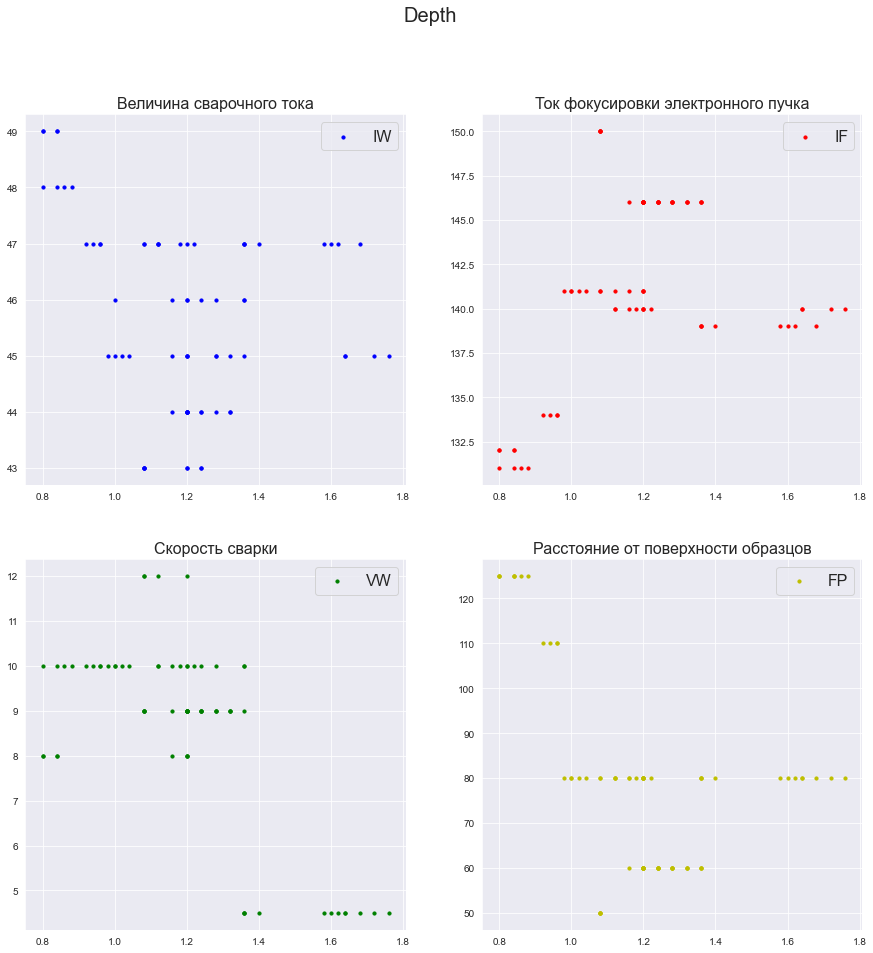

In [87]:
# попробуем визуально выявить зависимость и её тип с целевыми переменными для разных признаков
fig, axs = plt.subplots(2,2, figsize=(15,15))
x = data['Depth']
axs[0,0].scatter(x, data['IW'], s=10, c='b', label='IW')
axs[0,0].set_title('Величина сварочного тока', fontsize=16)
axs[0,0].legend(fontsize=16)
axs[0,1].scatter(x, data['IF'], s=10, c='r', label='IF')
axs[0,1].set_title('Ток фокусировки электронного пучка', fontsize=16)
axs[0,1].legend(fontsize=16)
axs[1,0].scatter(x, data['VW'], s=10, c='g', label='VW')
axs[1,0].set_title('Скорость сварки', fontsize=16)
axs[1,0].legend(fontsize=16)
axs[1,1].scatter(x, data['FP'], s=10, c='y', label='FP')
axs[1,1].set_title('Расстояние от поверхности образцов', fontsize=16)
axs[1,1].legend(fontsize=16)
fig.suptitle("Depth", fontsize=20)
plt.show()


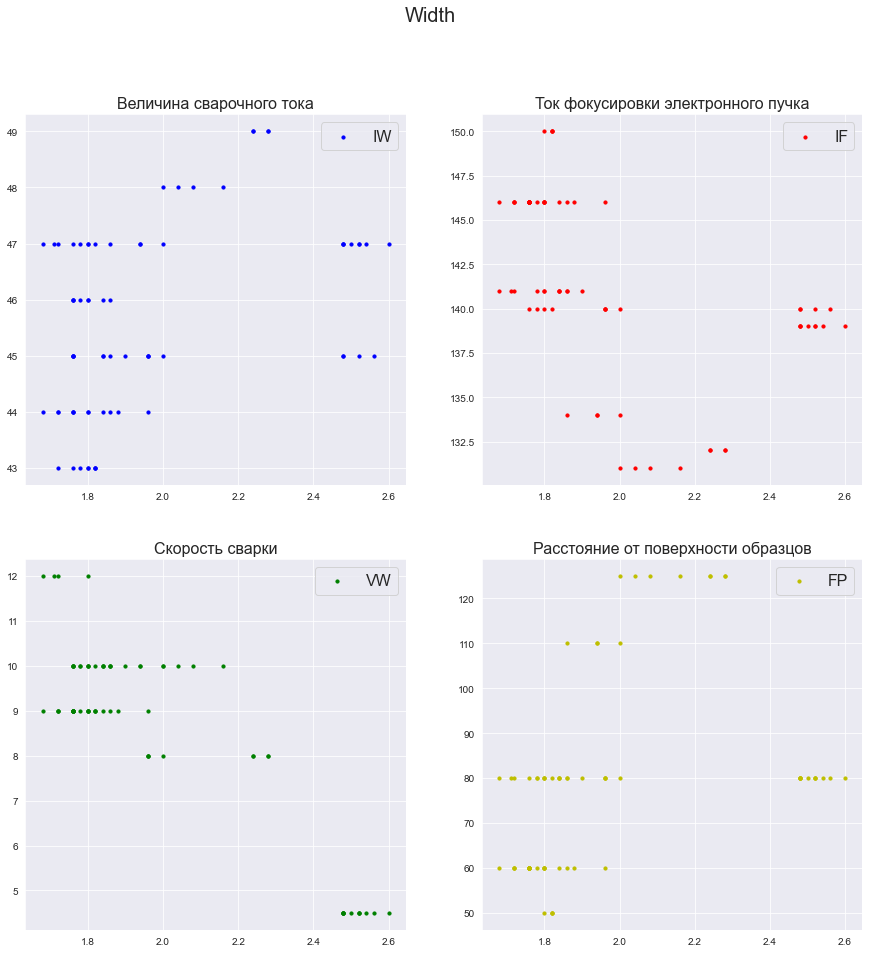

In [89]:
# попробуем визуально выявить зависимость и её тип с целевыми переменными для разных признаков
fig, axs = plt.subplots(2,2, figsize=(15,15))
x = data['Width']
axs[0,0].scatter(x, data['IW'], s=10, c='b', label='IW')
axs[0,0].set_title('Величина сварочного тока', fontsize=16)
axs[0,0].legend(fontsize=16)
axs[0,1].scatter(x, data['IF'], s=10, c='r', label='IF')
axs[0,1].set_title('Ток фокусировки электронного пучка', fontsize=16)
axs[0,1].legend(fontsize=16)
axs[1,0].scatter(x, data['VW'], s=10, c='g', label='VW')
axs[1,0].set_title('Скорость сварки', fontsize=16)
axs[1,0].legend(fontsize=16)
axs[1,1].scatter(x, data['FP'], s=10, c='y', label='FP')
axs[1,1].set_title('Расстояние от поверхности образцов', fontsize=16)
axs[1,1].legend(fontsize=16)
fig.suptitle("Width", fontsize=20)
plt.show()

In [92]:
# Данные ложатся "пластами", это может помешать качественному предсказанию
# попробуем посчитать рапределения по группам
# в идеале ожидается что для каждого сочетания 'IW','IF','VW','FP' будет 4 замера
grouped_data = data.groupby(['IW','IF','VW','FP']).count()
grouped_data
# выясняется что одна группа с одинаковыми параметрами может включать не 4 замера 
#а 8(47	139	4.5	80) или 12 (44	146	9.0	60)
# что тоже может сказаться на точности алгоритма ввиду несбалансированности данных

Depth  Width
IW IF  VW   FP               
43 146 9.0  60       4      4
   150 9.0  50       4      4
44 146 9.0  60      12     12
45 140 4.5  80       4      4
       8.0  80       4      4
   141 10.0 80       4      4
   146 9.0  60       4      4
46 141 10.0 80       4      4
   146 10.0 60       4      4
47 134 10.0 110      4      4
   139 4.5  80       8      8
   140 10.0 80       4      4
   141 12.0 80       4      4
48 131 10.0 125      4      4
49 132 8.0  125      4      4

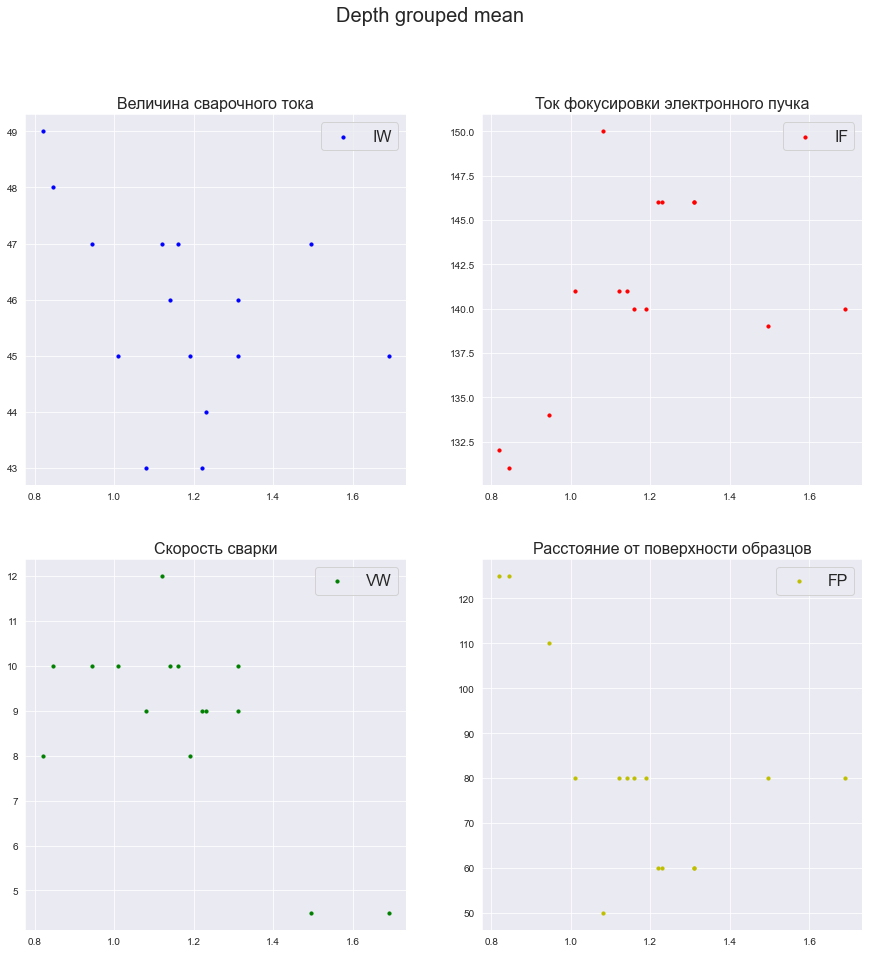

In [113]:
grouped_data_mean = data.groupby(['IW','IF','VW','FP']).mean().reset_index()
# попробуем визуально выявить зависимость дял средних значеий по группам
fig, axs = plt.subplots(2,2, figsize=(15,15))
x = grouped_data_mean['Depth']
axs[0,0].scatter(x, grouped_data_mean['IW'], s=10, c='b', label='IW')
axs[0,0].set_title('Величина сварочного тока', fontsize=16)
axs[0,0].legend(fontsize=16)
axs[0,1].scatter(x, grouped_data_mean['IF'], s=10, c='r', label='IF')
axs[0,1].set_title('Ток фокусировки электронного пучка', fontsize=16)
axs[0,1].legend(fontsize=16)
axs[1,0].scatter(x, grouped_data_mean['VW'], s=10, c='g', label='VW')
axs[1,0].set_title('Скорость сварки', fontsize=16)
axs[1,0].legend(fontsize=16)
axs[1,1].scatter(x, grouped_data_mean['FP'], s=10, c='y', label='FP')
axs[1,1].set_title('Расстояние от поверхности образцов', fontsize=16)
axs[1,1].legend(fontsize=16)
fig.suptitle("Depth grouped mean", fontsize=20)
plt.show()

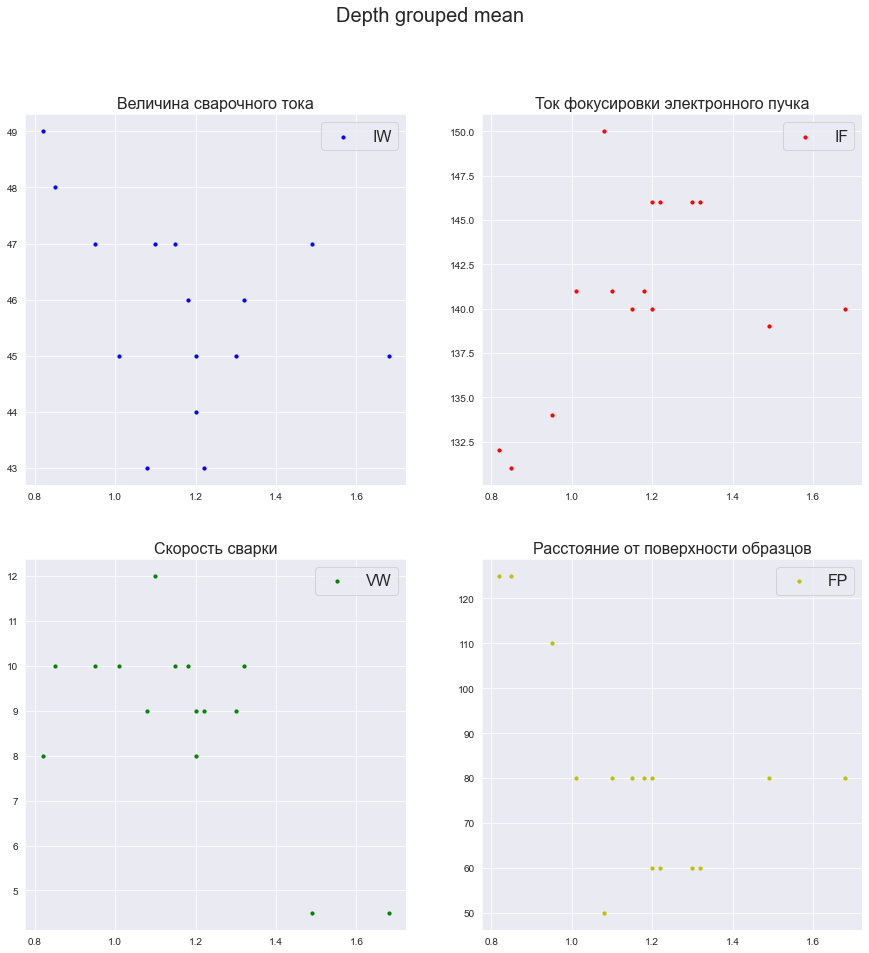

In [114]:
grouped_data_median = data.groupby(['IW','IF','VW','FP']).median().reset_index()
# попробуем визуально выявить зависимость для медианных значений по группам
fig, axs = plt.subplots(2,2, figsize=(15,15))
x = grouped_data_median['Depth']
axs[0,0].scatter(x, grouped_data_median['IW'], s=10, c='b', label='IW')
axs[0,0].set_title('Величина сварочного тока', fontsize=16)
axs[0,0].legend(fontsize=16)
axs[0,1].scatter(x, grouped_data_median['IF'], s=10, c='r', label='IF')
axs[0,1].set_title('Ток фокусировки электронного пучка', fontsize=16)
axs[0,1].legend(fontsize=16)
axs[1,0].scatter(x, grouped_data_median['VW'], s=10, c='g', label='VW')
axs[1,0].set_title('Скорость сварки', fontsize=16)
axs[1,0].legend(fontsize=16)
axs[1,1].scatter(x, grouped_data_median['FP'], s=10, c='y', label='FP')
axs[1,1].set_title('Расстояние от поверхности образцов', fontsize=16)
axs[1,1].legend(fontsize=16)
fig.suptitle("Depth grouped median", fontsize=20)
plt.show()

In [ ]:
# как выяснилось использование сокращённого набора данных не даёт преимуществ в предсказании на используемых моделях, а даже наоборот